In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import float32, zeros, ones, eye, as_tensor, tensor

from sbi.inference import MCMCPosterior, VIPosterior, ImportanceSamplingPosterior
from sbi.analysis import pairplot
from sbi.utils import mcmc_transform

from gbi.GBI import GBInference
from gbi.hh.train_gbi import MaeDistZ
import gbi.hh.utils as utils
from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

/home/michael/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Main figure is with 1 Million simulations

In [104]:
gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_09__08_21_33"
npe_path = "/home/michael/Documents/neuralgbi/results/hh/npe/2023_05_09__11_40_19"

In [105]:
with open(f"{gbi_path}/inference_gbi.pkl", "rb") as handle:
    inference_gbi = pickle.load(handle)
with open(f"{npe_path}/inference_npe.pkl", "rb") as handle:
    inference_npe = pickle.load(handle)

### Load simulator

In [106]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [107]:
true_params, labels_params = utils.obs_params(reduced_model=False)

list_cells_AllenDB = [518290966, 57, 0.0234 / 126]

ephys_cell = list_cells_AllenDB[0]
sweep_number = list_cells_AllenDB[1]
A_soma = list_cells_AllenDB[2]
junction_potential = -14

obs = utils.allen_obs_data(
    ephys_cell=ephys_cell, sweep_number=sweep_number, A_soma=A_soma
)
obs["data"] = obs["data"] + junction_potential
I = obs["I"]
dt = obs["dt"]
t_on = obs["t_on"]
t_off = obs["t_off"]

sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

### Load prior

In [7]:
prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T

### Load allen cell data

In [8]:
obs_stats_ls, all_obs = utils.load_all_allen()

In [138]:
with open("allen_data/allen_theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("allen_data/allen_summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

In [139]:
prior_av_dists = []
for xo in obs_stats_ls:
    dists = inference_gbi.distance_func(x[:1000].unsqueeze(1), xo)
    prior_av_dists.append(torch.mean(dists))

# GBI

### Evaluate the distance estimator

In [13]:
# # Generate 10 simulations for 100 thetas
# _ = torch.manual_seed(111)

# theta_vals = prior.sample((100,))
# seeds = torch.randint(0, 100000, (100, 10))
# final_stats = []
# for theta_ind, theta_val in enumerate(theta_vals):
#     all_summstats = []
#     for iter_ in range(10):  # 10 sims per theta
#         x_val = sim.gen_single(theta_val, seed=seeds[theta_ind, iter_])
#         summstats = stats.calc([x_val])
#         all_summstats.append(summstats)
#     final_stats.append(all_summstats)

# final_stats = np.asarray(final_stats)
# final_stats = torch.as_tensor(final_stats, dtype=torch.float32)
# final_stats = final_stats.squeeze()

# with open("01_prior_theta.pkl", "wb") as handle:
#     pickle.dump(theta_vals, handle)
# with open("01_prior_pred.pkl", "wb") as handle:
#     pickle.dump(final_stats, handle)

In [19]:
with open("01_prior_theta.pkl", "rb") as handle:
    theta_vals = pickle.load(handle)
with open("01_prior_pred.pkl", "rb") as handle:
    final_stats = pickle.load(handle)

x_target_vals = torch.as_tensor(obs_stats_ls, dtype=torch.float32)[:5]

pred_dists = np.asarray([inference_gbi.predict_distance(theta_vals, x_target_val).detach().numpy() for x_target_val in x_target_vals])
true_dists = np.asarray([inference_gbi.distance_func(final_stats, x_target_val).numpy() for x_target_val in x_target_vals])

In [130]:
cols = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
]

### Draw samples from posterior

In [59]:
def sample_gbi_all_xo(beta):
    all_samples = []
    for xo in x_target_vals:
        xo = as_tensor(xo)
        potential_fn = inference_gbi.get_potential(x_o=xo, beta=beta)
        theta_transform = mcmc_transform(prior)

        posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=50,
            num_chains=100,
            init_strategy="resample",
            frac_chains_to_finish=0.9,
        )
        posterior_samples = posterior.sample((1_000,), frac_chains_to_finish=0.9)
        all_samples.append(posterior_samples)
    return all_samples

In [86]:
betas = [4.0, 10.0, 25.0, 60.0, 150.0]

In [88]:
# _ = torch.manual_seed(222)
# samples_gbi_beta10 = sample_gbi_all_xo(betas[0])
# with open("samples_gbi_beta10.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta10, handle)

# _ = torch.manual_seed(333)
# samples_gbi_beta50 = sample_gbi_all_xo(betas[1])
# with open("samples_gbi_beta50.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta50, handle)

# _ = torch.manual_seed(444)
# samples_gbi_beta250 = sample_gbi_all_xo(betas[2])
# with open("samples_gbi_beta250.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta250, handle)

# _ = torch.manual_seed(999)
# samples_gbi_beta600 = sample_gbi_all_xo(betas[3])
# with open("samples_gbi_beta600.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta600, handle)

# _ = torch.manual_seed(1111)
# samples_gbi_beta1500 = sample_gbi_all_xo(betas[4])
# with open("samples_gbi_beta1500.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta1500, handle)

In [89]:
with open("samples_gbi_beta10.pkl", "rb") as handle:
    samples_gbi_beta10 = pickle.load(handle)
with open("samples_gbi_beta50.pkl", "rb") as handle:
    samples_gbi_beta50 = pickle.load(handle)
with open("samples_gbi_beta250.pkl", "rb") as handle:
    samples_gbi_beta250 = pickle.load(handle)
with open("samples_gbi_beta600.pkl", "rb") as handle:
    samples_gbi_beta600 = pickle.load(handle)
with open("samples_gbi_beta1500.pkl", "rb") as handle:
    samples_gbi_beta1500 = pickle.load(handle)

### Evaluate distance estimator on posterior samples

### Posterior predictives

In [94]:
# all_predictive_stats_gbi1500 = []
# all_predictive_traces_gbi1500 = []
# for posterior_samples in samples_gbi_beta1500:
#     r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
#     stats_ = stats.calc(r)
#     all_predictive_stats_gbi1500.append(torch.as_tensor(stats_, dtype=torch.float32))
#     all_predictive_traces_gbi1500.append(r)

# all_predictive_stats_gbi600 = []
# all_predictive_traces_gbi600 = []
# for posterior_samples in samples_gbi_beta600:
#     r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
#     stats_ = stats.calc(r)
#     all_predictive_stats_gbi600.append(torch.as_tensor(stats_, dtype=torch.float32))
#     all_predictive_traces_gbi600.append(r)

# all_predictive_stats_gbi250 = []
# all_predictive_traces_gbi250 = []
# for posterior_samples in samples_gbi_beta250:
#     r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
#     stats_ = stats.calc(r)
#     all_predictive_stats_gbi250.append(torch.as_tensor(stats_, dtype=torch.float32))
#     all_predictive_traces_gbi250.append(r)

# all_predictive_stats_gbi50 = []
# all_predictive_traces_gbi50 = []
# for posterior_samples in samples_gbi_beta50:
#     r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
#     stats_ = stats.calc(r)
#     all_predictive_stats_gbi50.append(torch.as_tensor(stats_, dtype=torch.float32))
#     all_predictive_traces_gbi50.append(r)

# all_predictive_stats_gbi10 = []
# all_predictive_traces_gbi10 = []
# for posterior_samples in samples_gbi_beta10:
#     r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
#     stats_ = stats.calc(r)
#     all_predictive_stats_gbi10.append(torch.as_tensor(stats_, dtype=torch.float32))
#     all_predictive_traces_gbi10.append(r)
    
# with open("02_posterior10_pred_stats.pkl", "wb") as handle:
#     pickle.dump(all_predictive_stats_gbi10, handle)
# with open("02_posterior50_pred_stats.pkl", "wb") as handle:
#     pickle.dump(all_predictive_stats_gbi50, handle)
# with open("02_posterior250_pred_stats.pkl", "wb") as handle:
#     pickle.dump(all_predictive_stats_gbi250, handle)
# with open("02_posterior600_pred_stats.pkl", "wb") as handle:
#     pickle.dump(all_predictive_stats_gbi600, handle)
# with open("02_posterior1500_pred_stats.pkl", "wb") as handle:
#     pickle.dump(all_predictive_stats_gbi1500, handle)
    
# with open("02_posterior10_pred_traces.pkl", "wb") as handle:
#     pickle.dump(all_predictive_traces_gbi10, handle)
# with open("02_posterior50_pred_traces.pkl", "wb") as handle:
#     pickle.dump(all_predictive_traces_gbi50, handle)
# with open("02_posterior250_pred_traces.pkl", "wb") as handle:
#     pickle.dump(all_predictive_traces_gbi250, handle)
# with open("02_posterior600_pred_traces.pkl", "wb") as handle:
#     pickle.dump(all_predictive_traces_gbi600, handle)
# with open("02_posterior1500_pred_traces.pkl", "wb") as handle:
#     pickle.dump(all_predictive_traces_gbi1500, handle)

In [95]:
with open("02_posterior10_pred_stats.pkl", "rb") as handle:
    all_predictive_stats_gbi10 = pickle.load(handle)
with open("02_posterior50_pred_stats.pkl", "rb") as handle:
    all_predictive_stats_gbi50 = pickle.load(handle)
with open("02_posterior250_pred_stats.pkl", "rb") as handle:
    all_predictive_stats_gbi250 = pickle.load(handle)
with open("02_posterior600_pred_stats.pkl", "rb") as handle:
    all_predictive_stats_gbi600 = pickle.load(handle)
with open("02_posterior1500_pred_stats.pkl", "rb") as handle:
    all_predictive_stats_gbi1500 = pickle.load(handle)
    
with open("02_posterior10_pred_traces.pkl", "rb") as handle:
    all_predictive_traces_gbi10 = pickle.load(handle)
with open("02_posterior50_pred_traces.pkl", "rb") as handle:
    all_predictive_traces_gbi50 = pickle.load(handle)
with open("02_posterior250_pred_traces.pkl", "rb") as handle:
    all_predictive_traces_gbi250 = pickle.load(handle)
with open("02_posterior600_pred_traces.pkl", "rb") as handle:
    all_predictive_traces_gbi600 = pickle.load(handle)
with open("02_posterior1500_pred_traces.pkl", "rb") as handle:
    all_predictive_traces_gbi1500 = pickle.load(handle)

### Evaluate distance estimator on posterior samples

In [96]:
all_theta_vals = [samples_gbi_beta10, samples_gbi_beta50, samples_gbi_beta250, samples_gbi_beta600, samples_gbi_beta1500]
all_final_stats = [all_predictive_stats_gbi10, all_predictive_stats_gbi50, all_predictive_stats_gbi250, all_predictive_stats_gbi600, all_predictive_stats_gbi1500]

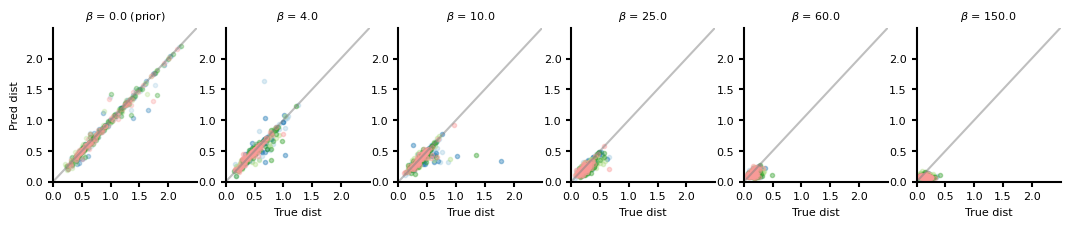

In [137]:
cols = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
]
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 6, figsize=(13, 2))
    with open("01_prior_theta.pkl", "rb") as handle:
        theta_vals = pickle.load(handle)
    with open("01_prior_pred.pkl", "rb") as handle:
        final_stats = pickle.load(handle)

    x_target_vals = torch.as_tensor(obs_stats_ls, dtype=torch.float32)[:5]

    pred_dists = np.asarray([inference_gbi.predict_distance(theta_vals, x_target_val).detach().numpy() for x_target_val in x_target_vals])
    true_dists = np.asarray([inference_gbi.distance_func(final_stats, x_target_val).numpy() for x_target_val in x_target_vals])
    
    _ = ax[0].plot([0, 2.5], [0, 2.5], c="grey", alpha=0.5)
    for i in range(5):
        t = true_dists[i]
        p = pred_dists[i]
        _ = ax[0].scatter(t, p, c=cols[i], alpha=.3)
        ax[0].set_xticks(np.arange(0, 2.5, 0.5))
        ax[0].set_yticks(np.arange(0, 2.5, 0.5))

    for beta_ind in range(5):
        theta_vals = all_theta_vals[beta_ind]
        final_stats = all_final_stats[beta_ind]
        
        pred_dists = np.asarray([inference_gbi.predict_distance(theta_vals[i][:100], x_target_vals[i]).detach().numpy() for i in range(5)])
        true_dists = np.asarray([inference_gbi.distance_func(final_stats[i].unsqueeze(1), x_target_vals[i]).numpy() for i in range(5)])
        
        _ = ax[1+beta_ind].plot([0, 2.5], [0, 2.5], c="grey", alpha=0.5)
        
        for i in range(5):
            t = true_dists[i]
            p = pred_dists[i]
            _ = ax[1+beta_ind].scatter(t, p, c=cols[i], alpha=.4)
            _ = ax[1+beta_ind].set_xlabel("True dist")
            _ = ax[0].set_ylabel("Pred dist")
            _ = ax[1+beta_ind].set_xticks(np.arange(0, 2.5, 0.5))
            _ = ax[1+beta_ind].set_yticks(np.arange(0, 2.5, 0.5))
        
        ax[0].set_title(r"$\beta$ = 0.0 (prior)")
        ax[1].set_title(r"$\beta$ = 4.0")
        ax[2].set_title(r"$\beta$ = 10.0")
        ax[3].set_title(r"$\beta$ = 25.0")
        ax[4].set_title(r"$\beta$ = 60.0")
        ax[5].set_title(r"$\beta$ = 150.0")
        
    for i in range(6):
        ax[i].set_xlim([0, 2.5])
        ax[i].set_ylim([0, 2.5])

In [101]:
gbi1500_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi1500, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi1500_av_dists.append(torch.mean(dists))

gbi600_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi600, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi600_av_dists.append(torch.mean(dists))

gbi250_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi250, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi250_av_dists.append(torch.mean(dists))

gbi50_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi50, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi50_av_dists.append(torch.mean(dists))

gbi10_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi10, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi10_av_dists.append(torch.mean(dists))

In [102]:
time_vec_obs = np.linspace(np.min(sim.t), np.max(sim.t), len(all_obs[0]["data"]))

### beta = low

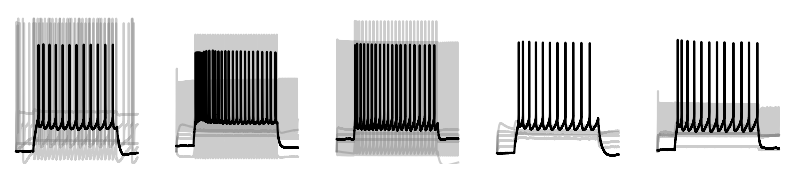

In [74]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        predictives = all_predictive_traces_gbi10[i]
        xo = all_obs[i]
        for p in predictives[:5]:
            _ = ax[i].plot(sim.t, p["data"], c="grey", alpha=0.4)
        _ = ax[i].plot(time_vec_obs, xo["data"], c="k")
        
        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])

### beta = middle

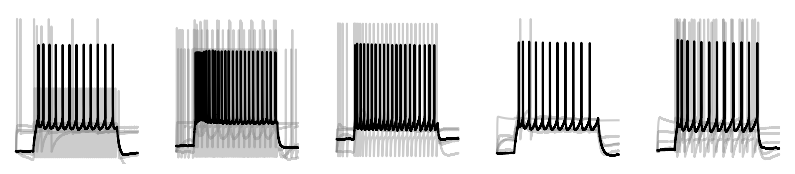

In [75]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        predictives = all_predictive_traces_gbi50[i]
        xo  = all_obs[i]
        for p in predictives[:5]:
            _ = ax[i].plot(sim.t, p["data"], c="grey", alpha=0.4)
        _ = ax[i].plot(time_vec_obs, xo["data"], c="k")
            
        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])

### beta = high

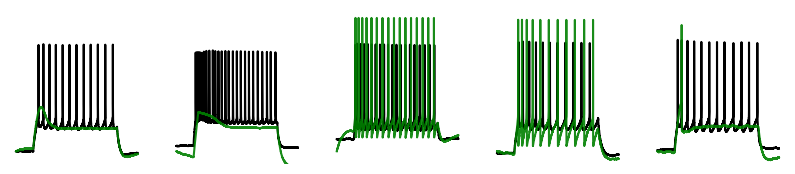

In [77]:
for j in range(1):

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 5, figsize=(10, 2))
        for i in range(5):
            predictives = all_predictive_traces_gbi250[i]
            xo  = all_obs[i]
            _ = ax[i].plot(time_vec_obs, xo["data"], c="k")
            for p in predictives[j:j+1]:
                _ = ax[i].plot(sim.t, p["data"], c="green", alpha=0.9)

            _ = ax[i].set_xlabel("")
            _ = ax[i].set_ylabel("")
            _ = ax[i].set_ylim([-100, 60])
            _ = ax[i].spines["left"].set_visible(False)
            _ = ax[i].spines["bottom"].set_visible(False)
            _ = ax[i].set_xticks([])
            _ = ax[i].set_yticks([])
    plt.show()

### beta = very high

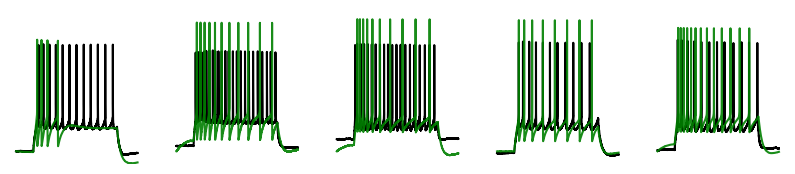

In [78]:
for j in range(1):

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 5, figsize=(10, 2))
        for i in range(5):
            predictives = all_predictive_traces_gbi600[i]
            xo  = all_obs[i]
            _ = ax[i].plot(time_vec_obs, xo["data"], c="k")
            for p in predictives[j:j+1]:
                _ = ax[i].plot(sim.t, p["data"], c="green", alpha=0.9)

            _ = ax[i].set_xlabel("")
            _ = ax[i].set_ylabel("")
            _ = ax[i].set_ylim([-100, 60])
            _ = ax[i].spines["left"].set_visible(False)
            _ = ax[i].spines["bottom"].set_visible(False)
            _ = ax[i].set_xticks([])
            _ = ax[i].set_yticks([])
    plt.show()

### beta = max

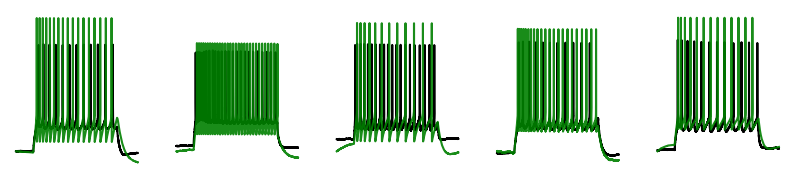

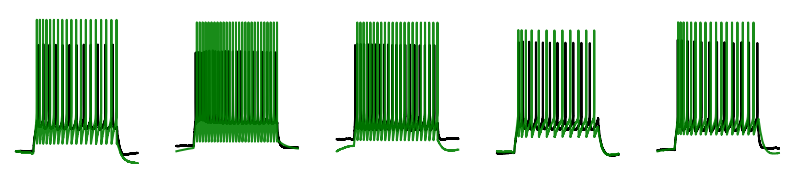

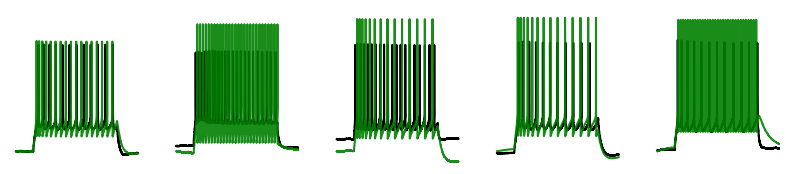

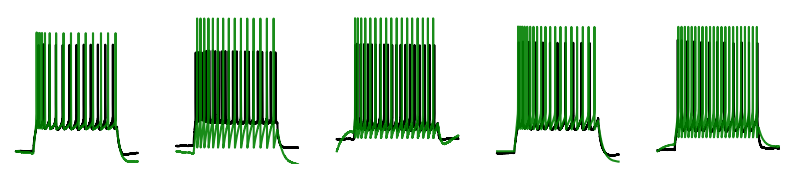

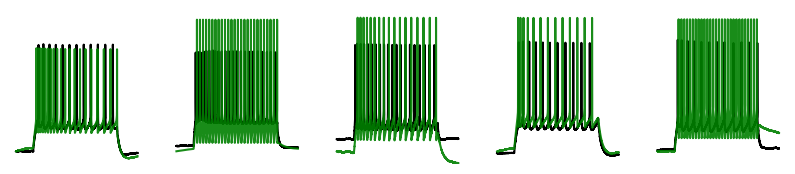

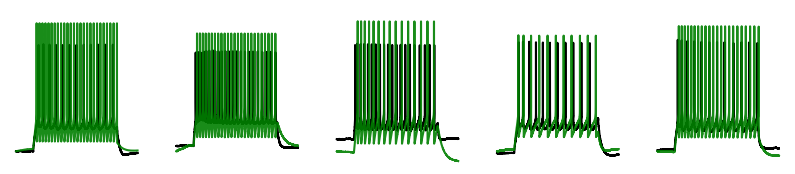

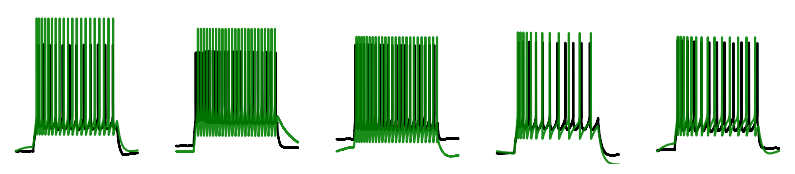

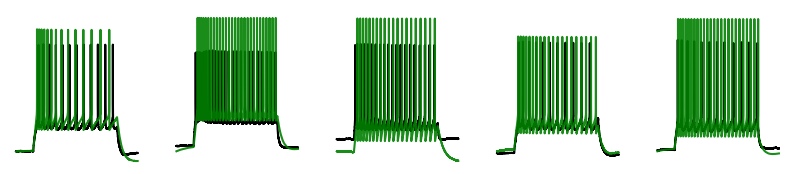

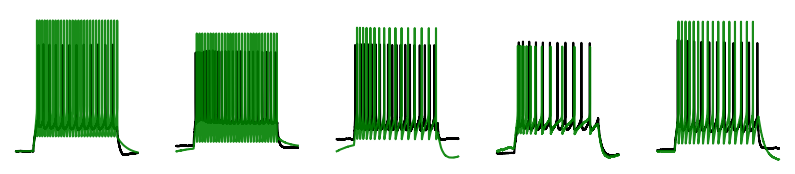

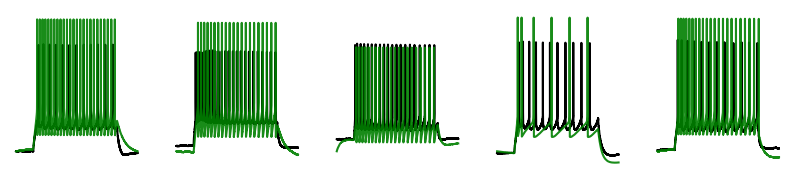

In [124]:
for j in range(10):

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 5, figsize=(10, 2))
        for i in range(5):
            predictives = all_predictive_traces_gbi1500[i]
            xo  = all_obs[i]
            _ = ax[i].plot(time_vec_obs, xo["data"], c="k")
            for p in predictives[j:j+1]:
                _ = ax[i].plot(sim.t, p["data"], c="green", alpha=0.9)

            _ = ax[i].set_xlabel("")
            _ = ax[i].set_ylabel("")
            _ = ax[i].set_ylim([-100, 60])
            _ = ax[i].spines["left"].set_visible(False)
            _ = ax[i].spines["bottom"].set_visible(False)
            _ = ax[i].set_xticks([])
            _ = ax[i].set_yticks([])
    plt.show()

# NPE

In [112]:
_ = torch.manual_seed(2222)

npe_all_samples = []
maps = []
for xo in obs_stats_ls[:5]:
    xo = as_tensor(xo)
    posterior = inference_npe.build_posterior()
    posterior_samples = posterior.sample((1_000,), x=xo)
    npe_all_samples.append(posterior_samples)

Drawing 1000 posterior samples: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 34819.06it/s]


In [113]:
_ = torch.manual_seed(3333)

all_predictive_traces = []
all_predictive_stats = []
for posterior_samples in npe_all_samples:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    all_predictive_traces.append(r)
    stats_ = stats.calc(r)
    all_predictive_stats.append(torch.as_tensor(stats_, dtype=torch.float32))

with open("03_npe_theta.pkl", "wb") as handle:
    pickle.dump(npe_all_samples, handle)
with open("03_npe_stats.pkl", "wb") as handle:
    pickle.dump(all_predictive_stats, handle)
with open("03_npe_traces.pkl", "wb") as handle:
    pickle.dump(all_predictive_traces, handle)

In [115]:
with open("03_npe_theta.pkl", "rb") as handle:
    npe_all_samples = pickle.load(handle)
with open("03_npe_stats.pkl", "rb") as handle:
    all_predictive_stats = pickle.load(handle)
with open("03_npe_traces.pkl", "rb") as handle:
    all_predictive_traces = pickle.load(handle)

In [116]:
npe_av_dists = []
for predictives, xo in zip(all_predictive_stats, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    npe_av_dists.append(torch.mean(dists))

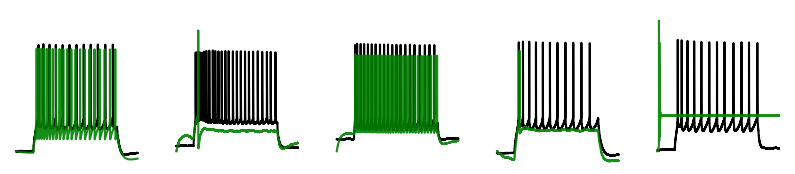

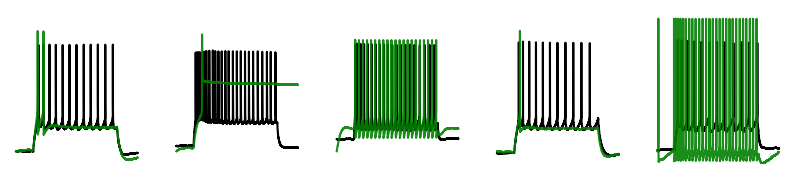

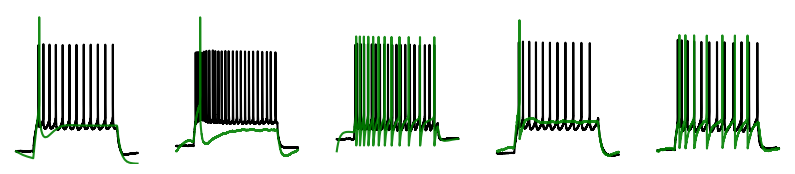

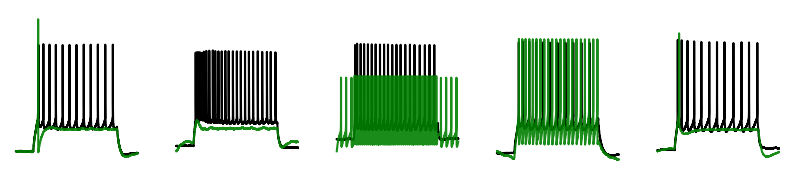

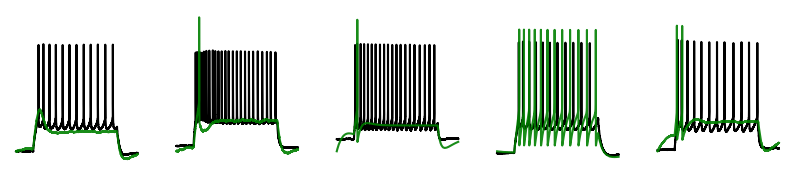

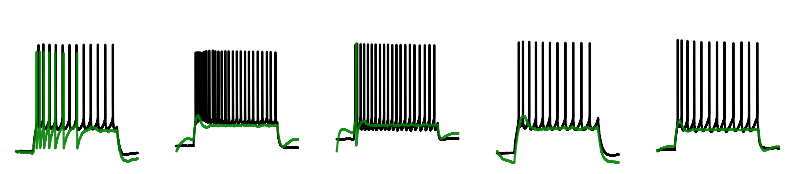

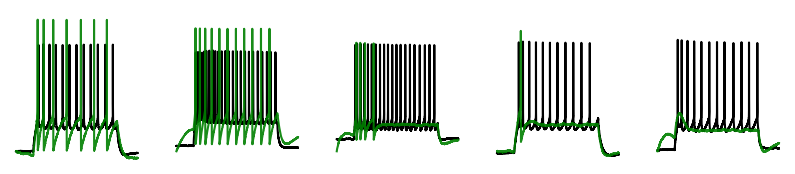

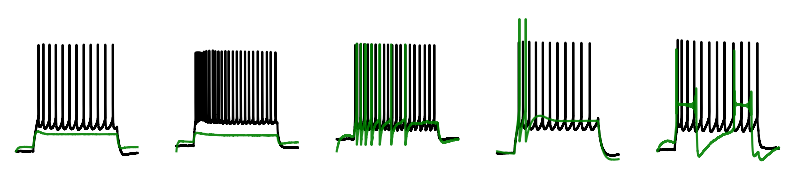

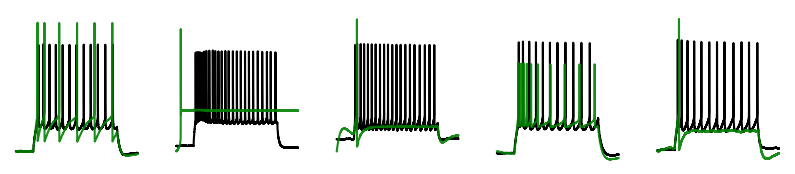

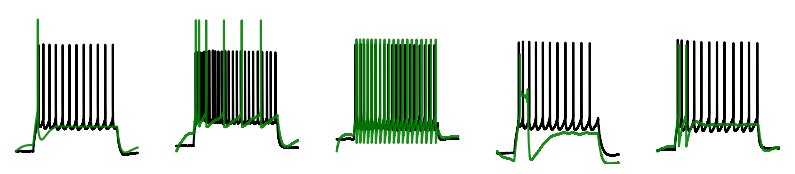

In [125]:
for j in range(10):

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 5, figsize=(10, 2))
        for i in range(5):
            predictives = all_predictive_traces[i]
            xo  = all_obs[i]
            _ = ax[i].plot(time_vec_obs, xo["data"], c="k")
            for p in predictives[j:j+1]:
                _ = ax[i].plot(sim.t, p["data"], c="green", alpha=0.9)

            _ = ax[i].set_xlabel("")
            _ = ax[i].set_ylabel("")
            _ = ax[i].set_ylim([-100, 60])
            _ = ax[i].spines["left"].set_visible(False)
            _ = ax[i].spines["bottom"].set_visible(False)
            _ = ax[i].set_xticks([])
            _ = ax[i].set_yticks([])
    plt.show()

# Compare NPE and GBI

In [140]:
prior_av_dists

[tensor(0.7682, dtype=torch.float64),
 tensor(0.7866, dtype=torch.float64),
 tensor(0.7468, dtype=torch.float64),
 tensor(0.7762, dtype=torch.float64),
 tensor(0.7566, dtype=torch.float64),
 tensor(0.8076, dtype=torch.float64),
 tensor(0.7522, dtype=torch.float64),
 tensor(0.7476, dtype=torch.float64),
 tensor(0.7698, dtype=torch.float64),
 tensor(0.7536, dtype=torch.float64)]

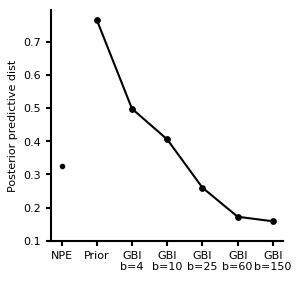

In [144]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    _ = ax.scatter([0], [np.mean(npe_av_dists)], c="k")
    _ = ax.plot([1, 2, 3, 4, 5, 6], [np.mean(prior_av_dists), np.mean(gbi10_av_dists), np.mean(gbi50_av_dists), np.mean(gbi250_av_dists), np.mean(gbi600_av_dists), np.mean(gbi1500_av_dists)])
    _ = ax.scatter([1, 2, 3, 4, 5, 6], [np.mean(prior_av_dists), np.mean(gbi10_av_dists), np.mean(gbi50_av_dists), np.mean(gbi250_av_dists), np.mean(gbi600_av_dists), np.mean(gbi1500_av_dists)], s=15)
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels(["NPE", "Prior", "GBI\nb=4", "GBI\nb=10", "GBI\nb=25", "GBI\nb=60", "GBI\nb=150"])
    ax.set_ylabel("Posterior predictive dist")
    ax.set_yticks(np.arange(0.1, 0.8, 0.1))
    plt.savefig("svg/panel_c.svg")
    plt.savefig("dist_plot.png", dpi=200, bbox_inches="tight")

/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarni

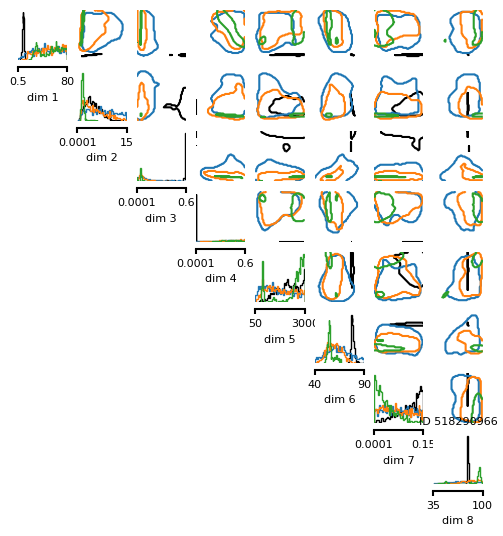

In [74]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = pairplot(
        [
            npe_all_samples[0], 
            samples_gbi_synth_beta10[0], 
            samples_gbi_synth_beta50[0], 
            samples_gbi_synth_beta250[0], 
        ],
        limits=limits,
        ticks=limits,
        upper="contour",
        contour_offdiag={"levels": [0.68], "percentile": True},
        figsize=(2.8, 2.8),
        diag="kde",
        subset=[0, 1, 2, 5, 7]
    )
    plt.savefig("svg/panel_d.svg")

### Assemble figure

In [75]:
import time
import IPython.display as IPd
from svgutils.compose import *

In [80]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("25.3cm", "17.1cm",
           
    Panel(
          SVG("svg/illustration.svg").scale(svg_scale),
          Text("a", -5, 2.0, **kwargs_text),
    ).move(10, 20),
           
    Panel(
          SVG("svg/panel_aa.svg").scale(svg_scale),
          Text("b", -5, 2.0, **kwargs_text),
    ).move(10, 20),
           
    Panel(
          SVG("svg/panel_a.svg").scale(svg_scale),
          Text("b", -5, 2.0, **kwargs_text),
    ).move(10, 20),
    
    Panel(
          SVG("svg/panel_b.svg").scale(svg_scale),
          Text("c", -5, 2.0, **kwargs_text),
    ).move(400, 20),
           
    Panel(
          SVG("svg/panel_c.svg").scale(svg_scale),
          Text("d", -5, 2.0, **kwargs_text),
    ).move(400, 20),
           
    Panel(
          SVG("svg/panel_d.svg").scale(svg_scale),
          Text("e", -5, 2.0, **kwargs_text),
    ).move(400, 20),
)

!mkdir -p fig
f.save("fig/fig_allen.svg")
svg("fig/fig_allen.svg")